# 1. Calculating centroid of small fibers
Kmeans <br>

In [356]:
import os
os.chdir("/Users/aartheebaskaran/Documents/Fiber_Project")

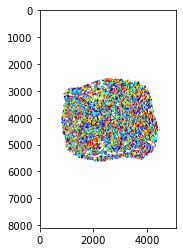

In [357]:
import skimage.io as ski
import matplotlib.pyplot as plt

# helpful (unnecessary) notebook plotting aid, change if 4
# %matplotlib notebook 
mask_name = "ORP6 expxc18bottomtilescan_cropped1_mask copy.tif"

fiber_masks = ski.imread(mask_name)
plt.imshow(fiber_masks) # Make sure plotting is correct

In [358]:
# Borrowed from https://bitbucket.org/william_rusnack/minimumboundingbox/src/master/

from scipy.spatial import ConvexHull
from math import sqrt

def get_minFD(points):

    hull_ordered = [points[index] for index in ConvexHull(points).vertices]
    hull_ordered.append(hull_ordered[0])
    hull_ordered = tuple(hull_ordered)

    min_rectangle = bounding_area(0, hull_ordered)
    for i in range(1, len(hull_ordered)-1):
        rectangle = bounding_area(i, hull_ordered)
        if rectangle['area'] < min_rectangle['area']:
            min_rectangle = rectangle
            
    return min_rectangle['length_orthogonal']

def bounding_area(index, hull):
    unit_vector_p = unit_vector(hull[index], hull[index+1])
    unit_vector_o = orthogonal_vector(unit_vector_p)
    
    dis_p = tuple(np.dot(unit_vector_p, pt) for pt in hull)
    dis_o = tuple(np.dot(unit_vector_o, pt) for pt in hull)
    
    min_p = min(dis_p)
    min_o = min(dis_o)
    len_orth = max(dis_o) - min_o
    len_p = max(dis_p) - min_p

    return {'area': len_p * len_orth,
            'length_orthogonal': len_orth,
           }

def unit_vector(pt0, pt1):
    # returns an unit vector that points in the direction of pt0 to pt1
    dis_0_to_1 = sqrt((pt0[0] - pt1[0])**2 + (pt0[1] - pt1[1])**2)
    return (pt1[0] - pt0[0]) / dis_0_to_1, \
           (pt1[1] - pt0[1]) / dis_0_to_1

def orthogonal_vector(vector):
    # from vector returns a orthogonal/perpendicular vector of equal length
    return -1 * vector[1], vector[0]

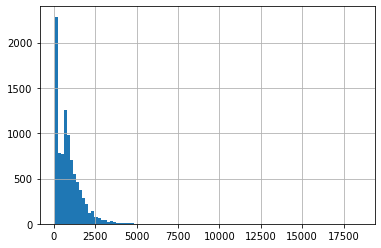

In [359]:
from skimage.color import rgb2gray 
from skimage.measure import label, regionprops, find_contours
import numpy as np

# Create labeled fibers from mask
gray_obj = rgb2gray(fiber_masks)
bw_obj = gray_obj[:,:] == 1
bw_obj = np.array(bw_obj, dtype='int')
label = label(bw_obj, background=1)# Make new image with regions colored corresponding to minFD:

import pandas as pd
from skimage.measure import regionprops_table

# Determine properties from label:
properties = ['label', 'area', 'centroid', 'coords']

tables = regionprops_table(label, properties=properties)
tables = pd.DataFrame(tables)

tables

tables = tables[tables['area'] > 10] 

tables['minFD'] = tables['coords'].apply(get_minFD)

# Convert centroid to int to line up with pixels:
tables = tables.astype({"centroid-0":int, "centroid-1":int})

tables 

fig, ax = plt.subplots()
ax = tables['area'].hist(bins=100) # quick histogram to view the data
plt.show()

In [360]:
# Make new image with regions colored corresponding to minFD:

img_size = fiber_masks.shape
img = np.zeros(img_size[0:2], dtype='int')
    
for i in range(len(tables['coords'])):
    try:
        img[tables['coords'][i][:,0], tables['coords'][i][:,1]] = tables['minFD'][i]
    except:
        print(f"Assignment failed at index: {i}")
        continue

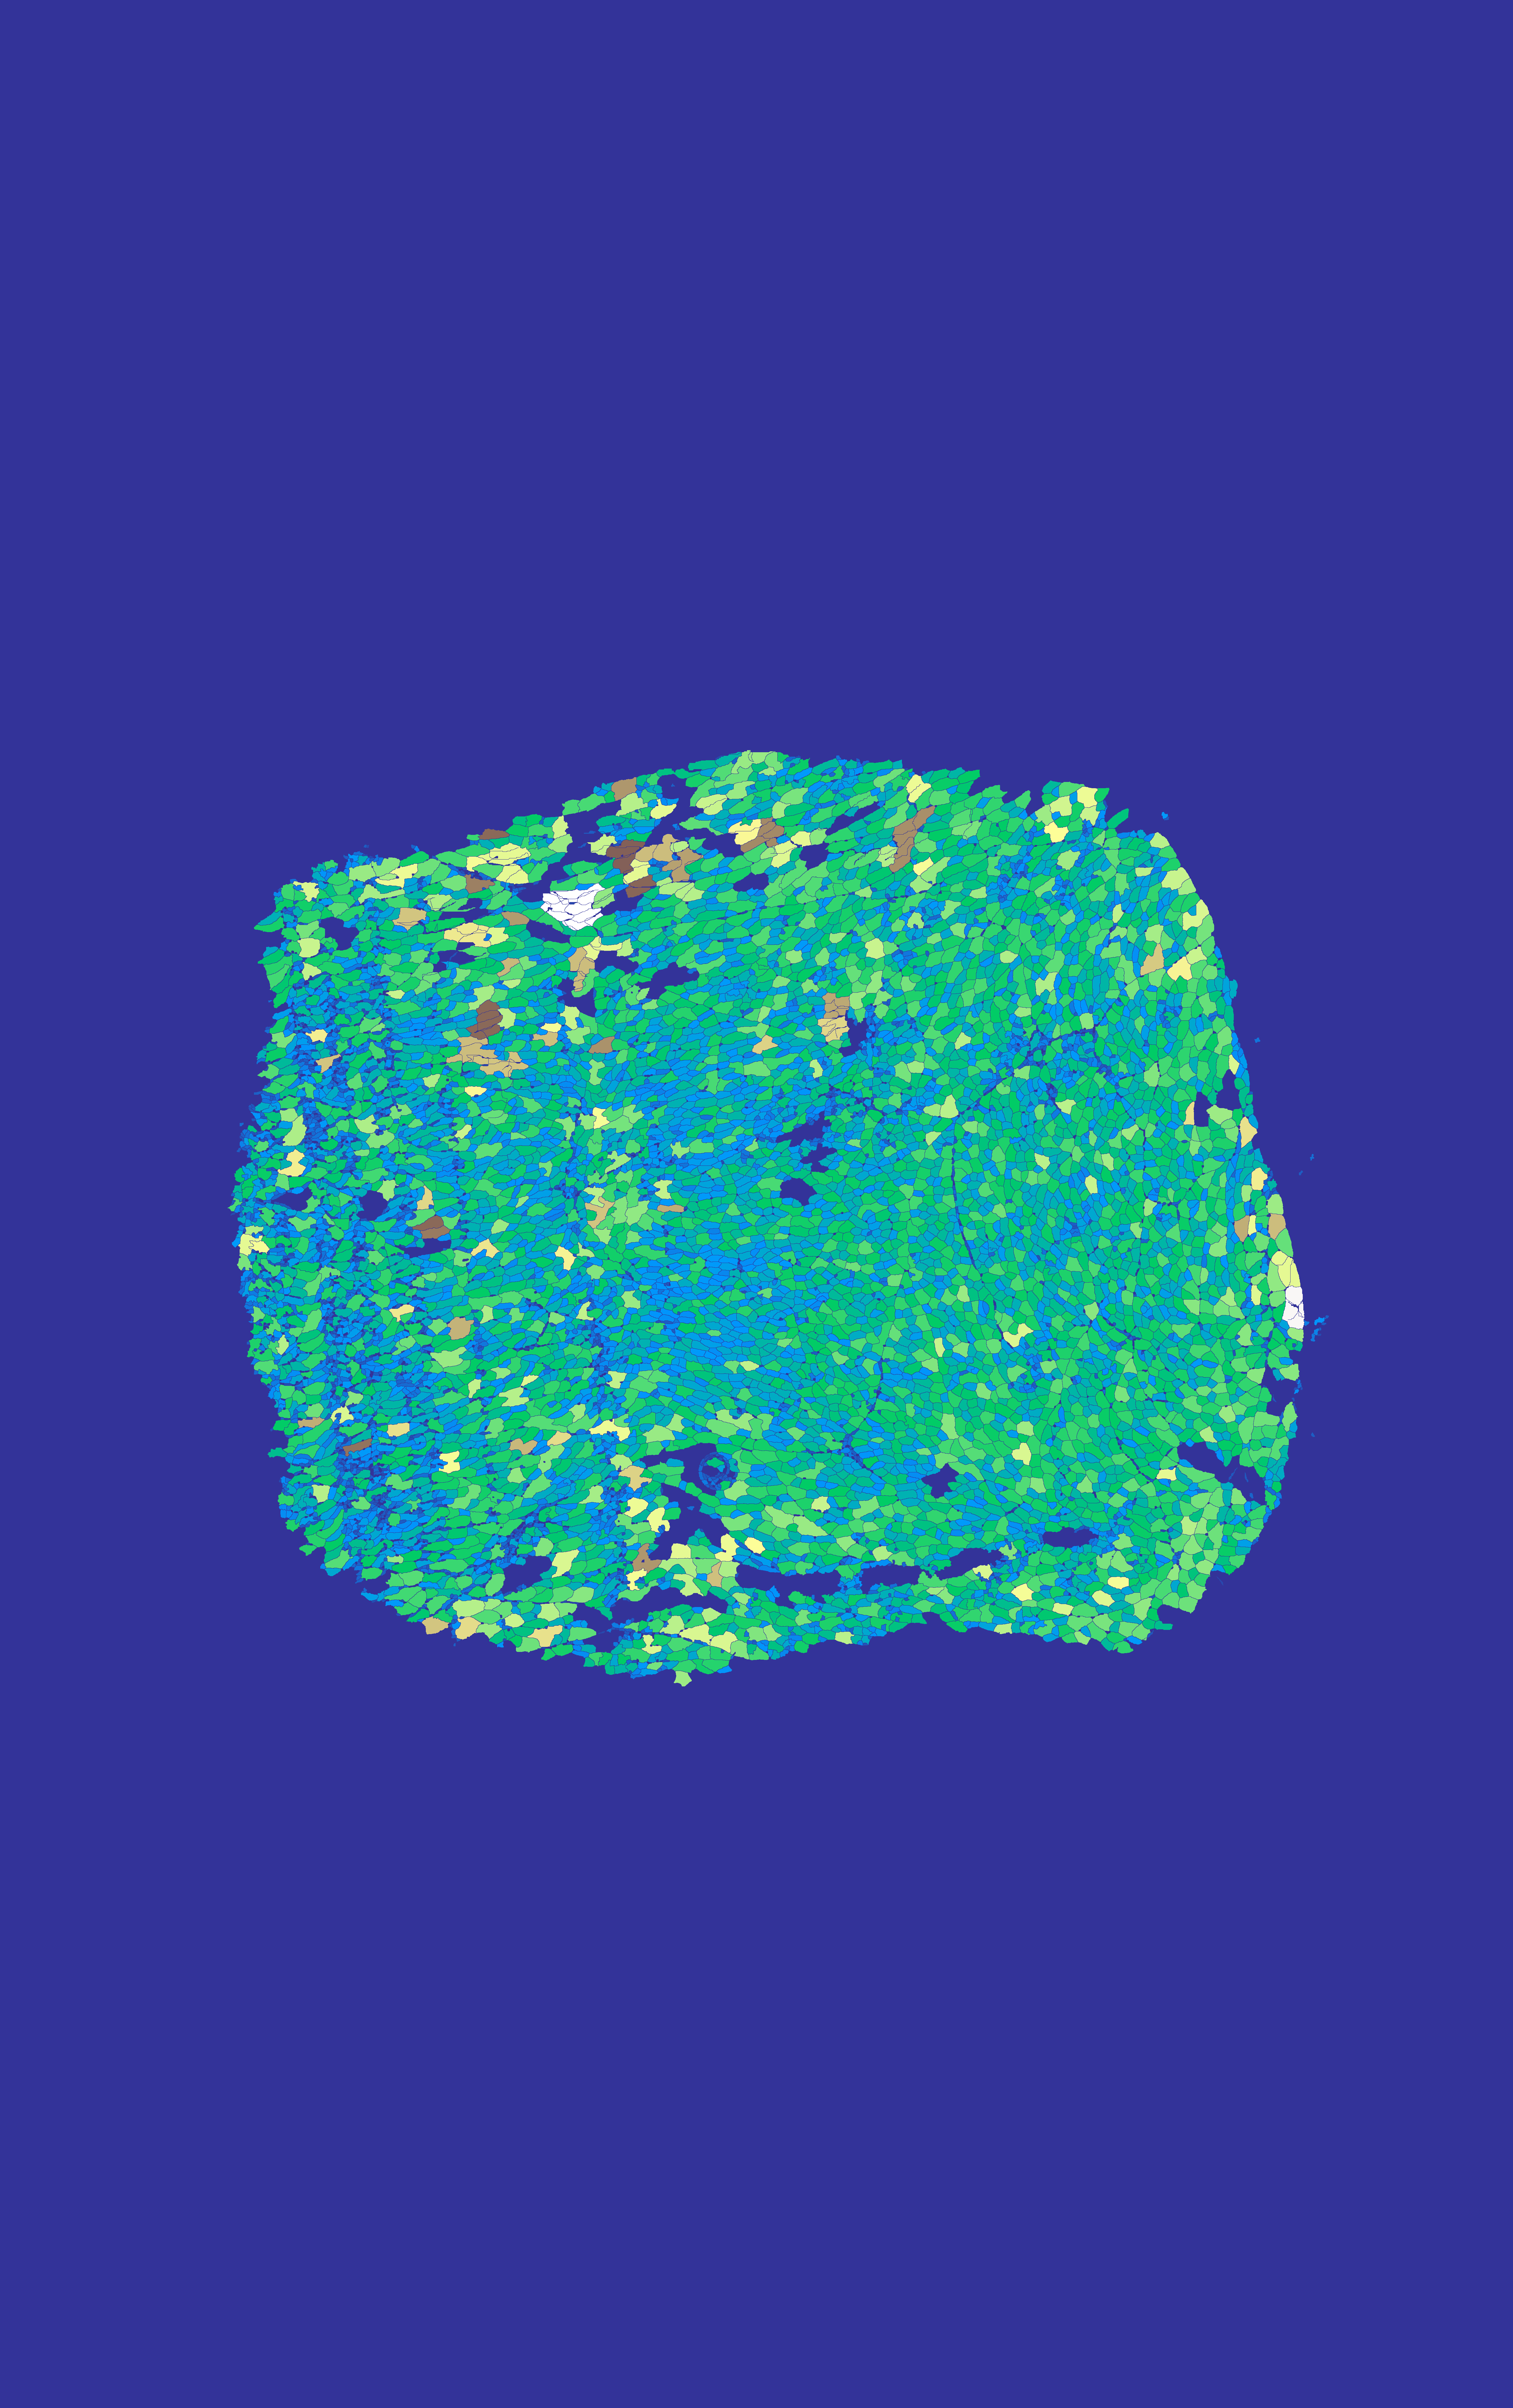

In [361]:
from PIL import Image

# Normalize: 
max_intensity = np.amax(img)
img = img / max_intensity

# Apply colormap
cm = plt.get_cmap("terrain")
img_out = cm(img)[:,:,0:3]

img_out = Image.fromarray((img_out * 255).astype(np.uint8))
img_out = img_out.convert('RGB')
# img_out.save("heatmap_out.tiff") # uncomment this to save the image

img_out # view image

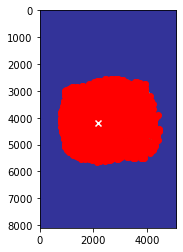

In [362]:
# Explore location of small fibers. Seems like they form a 'core' region

small_fibers = tables[tables['minFD'] < 25]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(small_fibers['centroid-1'], small_fibers['centroid-0'], c=[[1,0,0]])

# Find average location of small fibers:
ax.scatter(small_fibers['centroid-1'].mean(), small_fibers['centroid-0'].mean(), marker='x', color='w')


# Plotting: 
plt.imshow(img_out)
plt.show()

(<matplotlib.image.AxesImage at 0x7fe7f9619d90>,)

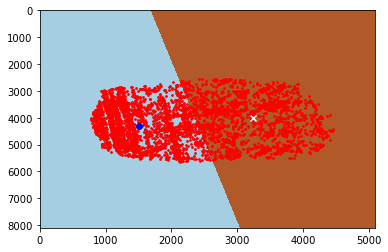

In [363]:
# Try K-means clustering to find center of cluster
# See https://scikit-learn.org/stable/modules/clustering.html#k-means

from sklearn.cluster import KMeans

centroids = small_fibers[['centroid-1', 'centroid-0']].to_numpy()
kmeans = KMeans(n_clusters=2, random_state=0).fit(centroids)

# Plot cluster regions:
[width, height] = img_out.size
xx, yy = np.meshgrid(np.arange(0, width), np.arange(0, height))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.axis([0,width,height,0])

# Plot original data and centroids
plt.scatter(small_fibers['centroid-1'], small_fibers['centroid-0'], c=[[1,0,0]], s=3)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='w', marker='x')

xcoord = kmeans.cluster_centers_[:,0][0]
ycoord = kmeans.cluster_centers_[:,1][0]
centroid = [xcoord, ycoord] 
plt.scatter(centroid[0], centroid[1], color = 'b', marker='o') # testing if centroid is the centroid we want 

plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower"),

# 2. Contouring the section

Grayscale, threshold, invert, and blur the image <br> 
Grayscaling and threshold is to get the mask into binary image (or two different colors to help with contouring) <br>
Blurring is because each fiber is still defined in the mask and the contour would be drawn around each fiber when we really want it around the whole section. Blurring make the section look like one uniform shape. <br>

## 2a. Grayscaling image

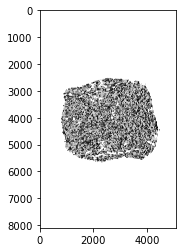

In [364]:
#http://creativemorphometrics.co.vu/blog/2014/08/05/automated-outlines-with-opencv-in-python/
import numpy as np
import cv2 #this is the main openCV class, the python binding file should be in /pythonXX/Lib/site-packages
from matplotlib import pyplot as plt

#Grayscaling image
gray = cv2.cvtColor(fiber_masks, cv2.COLOR_BGR2GRAY) #change to grayscale
gray = gray.astype(np.uint8)

plt.imshow(gray, cmap = "gray")
plt.show()

#plt.imsave("grayscaled.png", gray)

## 2b. Thresholding image

In [365]:
ret,thresh = cv2.threshold(gray,254,255,cv2.THRESH_BINARY) #100 gives a good image in the below chunk

#cv2.imshow("gray_thresholded image", thresh)
#cv2.waitKey(0)

#plt.imshow(thresh, cmap = "gray")
#plt.show

## 2c. Inverting colors

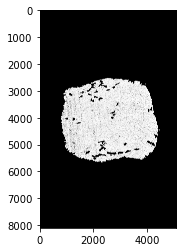

In [366]:
#https://stackoverflow.com/questions/19580102/inverting-image-in-python-with-opencv

inverted = cv2.bitwise_not(thresh)

#cv2.imshow("inverted image", inverted)
#cv2.waitKey(0)

plt.imshow(inverted, cmap = "gray")
plt.show()

## 2d. Blurring image

In [367]:
#https://medium.com/analytics-vidhya/gaussian-blurring-with-python-and-opencv-ba8429eb879b

blurred = cv2.GaussianBlur(inverted, (151,151), 0)

#cv2.imshow("blurred image", blurred)
#cv2.waitKey(0)

#plt.imshow(blurred, cmap = "gray")
#plt.show()

## 2e. Drawing contours

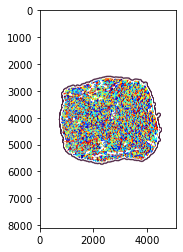

In [425]:
#https://likegeeks.com/python-image-processing/#Get_image_contour
#https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html

contours, hierarchy = cv2.findContours(blurred, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #find contours with simple approximation
cv2.drawContours(fiber_masks, contours, -1, (80, 40, 70), 50)

#cv2.imshow('Image Contours', fiber_masks)
#cv2.waitKey(0)

plt.imshow(fiber_masks)
plt.show()

# 3. Computing inner contour


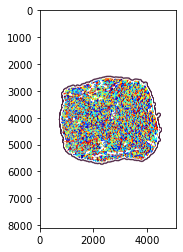

In [426]:
#Creating a duplicate fiber mask image
fiber = fiber_masks.copy()

plt.imshow(fiber)
plt.show()

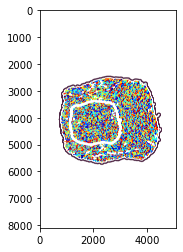

In [427]:
def small_contour_point(x1, y1, x2, y2, ratio):
    ratio = ratio/100
    small_contour_x = ((x2-x1)*ratio) + x1
    small_contour_y = ((y2-y1)*ratio) + y1
    return (small_contour_x, small_contour_y)

def finding_total_contour(contours, length):
    for x in range(0, length):
        max_length = len(contours[x])
        index = x
        if max_length < len(contours[x+1]):
            max_length = len(contours[x+1])
            index = x+1
    return index, max_length

small_contour = []

ratio = 50 #Modify here 

index, length = finding_total_contour(contours, len(contours)-1)
contours = contours[index]
    
for x in range(0, length-1):
    array = contours[x]
    
    if len(array) == 1:
        length2 = len(array)
    elif len(array) > 1:
        length2 = len(array)-1
    
    for y in range(0, length2):
        point = array[y]
        #point = point[0] #Need to fix this error (look at ctrl46 bottom - this was commented, NR6 bottom, older one for good run)
        contour_x = point[0]
        contour_y = point[1]
        new_point = small_contour_point(int(xcoord), int(ycoord), contour_x, contour_y, ratio) #xcoord and ycoord is centroid coordinates from kmeans
        small_contour.append(new_point)
        cv2.circle(fiber, (int(new_point[0]), int(new_point[1])), 50, [255,255,255], -1) #Color the outline white so that it's creating "two sections"
        
#cv2.imshow('New Contours', fiber)
#cv2.waitKey(0)
        
plt.imshow(fiber)
plt.show()

# 4. Quantifying Fibers in Core Area

## 4a. Creating binary filter (flood_fill)

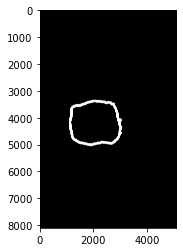

In [429]:
mask = np.zeros((fiber.shape[0], fiber.shape[1], fiber.shape[2]), dtype=np.uint8)

for x in range(0, len(small_contour)-1):
    cv2.circle(mask, (int(small_contour[x][0]), int(small_contour[x][1])), 50, [255,255,255], -1) #Color the outline white so that it's creating "two sections"
    
plt.imshow(mask)
plt.show()

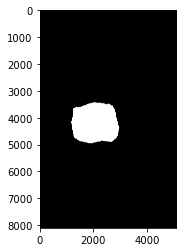

In [430]:
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill


filled_mask = flood_fill(mask, (2000,3500,0), 255) #need to mke this automated

if filled_mask[0,0][0] == 255:  #Sometimes the mask inverts so this make sure the mask has a black background      #255 means white
    filled_mask = cv2.bitwise_not(filled_mask)

plt.imshow(filled_mask)
plt.show()

## 4c. Applying filter to binary original mask

In [431]:
for y in range(0,fiber_masks.shape[1]): #https://scikit-image.org/docs/dev/user_guide/numpy_images.html
    for x in range(0,fiber_masks.shape[0]):
        if np.any(fiber_masks[x,y] != 255): 
            fiber_masks[x,y] = 50;

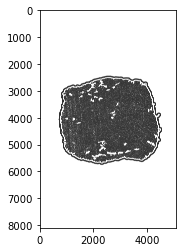

In [432]:
plt.imshow(fiber_masks)
plt.show()

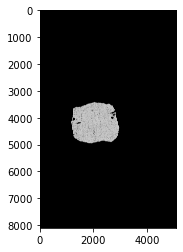

In [433]:
filtered = fiber_masks * filled_mask

#cv2.drawContours(filtered, contours, -1, (80, 40, 70), 50)
plt.imshow(filtered)
plt.show()

#plt.imsave("filtered.png", filtered)

In [434]:
fiber_count = 0
core_index = []
outer_index = []

for i in range(len(tables)):
    if np.any(filtered[tables['centroid-0'][i], tables['centroid-1'][i]] != 0):
        fiber_count += 1
        core_index.append(i)
    else:
        outer_index.append(i)

In [435]:
fiber_count

2365

# 5. Saving Files

## 5a. Making new folder and setting working director5

In [436]:
os.makedirs("NR: " + mask_name + ": " + str(ratio) + "% analysis")
os.chdir("NR: " + mask_name + ": " + str(ratio) + "% analysis")

## 5b. Saving heat map with defined region

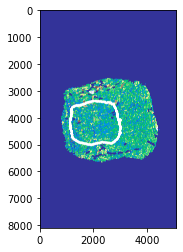

In [437]:
edited_heat_map = np.array(img_out) #https://stackoverflow.com/questions/54249728/opencv-typeerror-expected-cvumat-for-argument-src-what-is-this

for x in range(0, len(small_contour)-1):
    cv2.circle(edited_heat_map, (int(small_contour[x][0]), int(small_contour[x][1])), 50, [255,255,255], -1) #Color the outline white so that it's creating "two sections"

plt.imshow(edited_heat_map)
plt.show()

In [438]:
plt.imsave("heat map:  " + str(ratio) + "% region.png", edited_heat_map)

## 5c. Saving binary filled mask

In [439]:
plt.imsave(str(ratio) + "% Binary Mask.png", filled_mask)

## 5d. Saving filtered mask 

In [440]:
plt.imsave(str(ratio) + "% Filtered Mask.png", filtered)

# 6. Analyzing fiber densities

## 6a. Histograms for 'core region'

In [441]:
core_region_tables = pd.DataFrame()

for i in range(len(core_index)):
    j = core_index[i]
    row = {"area": tables.loc[j][1], "original index": j, "minFD": tables.loc[j][5]}
    core_region_tables = core_region_tables.append(row, ignore_index = True)

#core_region_tables

## 6b. Histograms for outer region

In [442]:
outer_region_tables = pd.DataFrame()

for i in range(len(outer_index)):
    j = outer_index[i]
    row = {"area": tables.loc[j][1], "original index": j, "minFD": tables.loc[j][5]} #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
    outer_region_tables = outer_region_tables.append(row, ignore_index = True) #https://www.stackvidhya.com/add-row-to-dataframe/

#outer_region_tables

## 6c. Overlapping Histograms and Summary Statistics for Areas

In [443]:
outer_area = outer_region_tables['area']
core_area = core_region_tables['area']

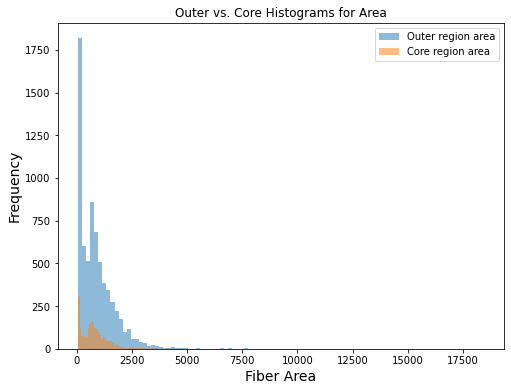

In [444]:
plt.figure(figsize=(8,6))
plt.hist(outer_area, bins=100, alpha=0.5, label="Outer region area")
plt.hist(core_area, bins=100, alpha=0.5, label="Core region area")
plt.xlabel("Fiber Area", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Outer vs. Core Histograms for Area")
plt.legend(loc='upper right')
plt.savefig("Outer_vs_Core_Area.png")
plt.show()

In [445]:
area_summary = pd.merge(outer_area.describe(), core_area.describe(), left_index=True, right_index=True, suffixes=('_outer','_core'))

In [446]:
area_summary.to_csv("Area_Summary.csv")

In [447]:
area_raw = pd.merge(outer_area, core_area, left_index=True, right_index=True, suffixes=('_outer','_core'))

In [448]:
area_raw.to_csv("Area_Raw.csv")

## 6d. Overlapping Histograms and Summary Statistics for minFDs

In [449]:
outer_minFD = outer_region_tables['minFD']
core_minFD = core_region_tables['minFD']

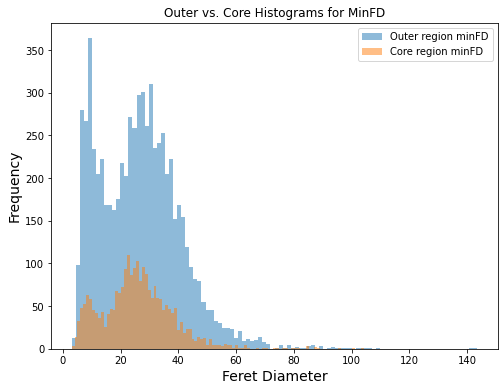

In [450]:
plt.figure(figsize=(8,6))
plt.hist(outer_minFD, bins=100, alpha=0.5, label="Outer region minFD")
plt.hist(core_minFD, bins=100, alpha=0.5, label="Core region minFD")
plt.xlabel("Feret Diameter", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Outer vs. Core Histograms for MinFD")
plt.legend(loc='upper right')
plt.savefig("Outer_vs_Core_minFD.png") #https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/
plt.show()

In [451]:
minFD_summary = pd.merge(outer_minFD.describe(), core_minFD.describe(), left_index=True, right_index=True, suffixes=('_outer','_core'))

In [452]:
minFD_summary.to_csv("minFD_Summary.csv")

In [453]:
minFD_raw = pd.merge(outer_minFD, core_minFD, left_index=True, right_index=True, suffixes=('_outer','_core'))

In [454]:
minFD_raw.to_csv("minFD_Raw.csv")